# (IMPORTANT) Ratio Analyses and Correcting Functions 

    MOST IMPORTANT NOTEBOOK:
    
    
    This Notebook is meant to analyze dataframe composed of calibration data and predicted fractions,
    which can subsequently be used for SynCom calibratio Data to extract  CORRECTION FUNCTION
    determining parameters:
        a2 := a list of 8 determined parabolic widths from fitted pB v C 
        hfit := a list of two values which are used to create a predictive function
            which spits out a likely h of the vertex (h,k) of a correcting parabola
            h(C) = np.poly1d([hfit[0], hfit[1]]), this 'h' is then used to calculate
            'b' = a1 in the function:
            y = a2*x**2 + a1*x + a0
            y = a*x**2 + b*x + c
        
        Once we have this value, which is in essence the added value that chlamy gives the bacterial
        fraction, we remove it from that function


In [1]:
import numpy as np
import pandas as pd
import os
import scipy

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

from os.path import join as pjoin

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Helper Functions

In [2]:
def get_series(tdf, column='440'):
    """Returns a specific column as a Pandas Series"""
    
    return tdf[column]


def plot_relationship(tdf, column='440'):

    """Given a wavelength of interest this function displays a
    plot of the sum of the predicted values vs the values at
    that wavelength"""
    
    s1 = get_series(tdf, column)
    sm = get_series(tdf, 'B_p'+column) + get_series(tdf, 'C_p'+column)
    
    sns.regplot(x=s1, y=sm)
    plt.show()
    plt.close()
    
    

def get_96position(tdf, column='440'):
    """Returns the values of wanted column (lamda) as a DataFrame
    resembling its 96well plate layout. Facilitates comparison"""
    ninsix = pd.DataFrame()
    for l in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        c = tdf[tdf.index.str.contains(l)][column].values
        ninsix[l] = c
    ninsix = ninsix.transpose()
    ninsix.columns = ninsix.columns+1

    return ninsix.round(6)


def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        #print(row)
        value = df.loc[(df['row']==row) & (df['col']==12), column].iloc[0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column].iloc[0]
        df.loc[df['col']==col, 'C'] = value
    
    return df

def plot_pred_vs_known(mdf, column='440', ml_model=False):
    
    """This function takes in the previously calculated prediction values and
    outputs the the predicted vs known values for [chlamy] and [bacter], 
    column refers to the variable wavelength used to construct the regression
    that gave rise to the predicted values"""
    
    df = mdf.copy()

    df = set_B_and_C(df, column)
    #print(df)
    # figsize
    fs = (8, 10)
    # alpha value for plot markers (see-throughness)
    a = 0.65
    # bacter figure
    fig0 = plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig0.add_subplot(gs[r,c]))

    
    #redline
    x = np.linspace(-5,5,20)
    y = x

    
    # get predicted values from column named
    if ml_model:
        Bp = 'B_pML_'+column
    else:
        Bp = 'B_p'+column
        print(Bp)
        
    if ml_model:
        Cp = 'C_pML_'+column
    else:
        Cp = 'C_p'+column
        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    #print(df['B'].max(), df['C'].max())
    smx = max(df[Bp].max(), df['B'].max(), df[Cp].max(), df['C'].max())
    smn = min(df[Bp].min(), df['B'].min(), df[Cp].min(), df['C'].min())
    
    #print(smx)
    smx = smx+0.05
    smn = smn-0.05
    
    sns.scatterplot(x='B', y=Bp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a, ax=axes[0])
    
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient',
                  loc=2, prop={'size':7})
    axes[0].set_title('Predicted vs. Actual [B]')
    axes[0].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[0].set_xlabel('$[B]_{known}$')

    axes[0].plot(x, y, '--r')
    #axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=smn, right=smx) 
    axes[0].set_ylim(bottom=smn, top=smx)


    sns.scatterplot(x='B', y=Bp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                   loc=2, prop={'size':7})
    axes[1].set_title('Predicted vs. Actual [B]')
    axes[1].set_ylabel('$\hat{[B]}$$_{pred}$')
    axes[1].set_xlabel('$[B]_{known}$')

    axes[1].plot(x, y, '--r')
    #axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=smn, right=smx)
    axes[1].set_ylim(bottom=smn, top=smx)

    if ml_model:
        fig0.suptitle("[Bacteria] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig0.suptitle("[Bacteria] Predictions Using Simple Linear Regression Models @"+column, y=.95)
        
    fig0.subplots_adjust(hspace=.3)
    
    #plt.show()
    #plt.close()



    # CHLAMY
    fig1=plt.figure(figsize=fs)
    gs = gridspec.GridSpec(2,1)
    axes = []
    for r in [0,1]:
        for c in [0]:
            axes.append(fig1.add_subplot(gs[r,c]))

        
    # set the scale maximum of the plot to be the maximum value of the maximum
    # of the predicted and known values, which -ever is greater
    smx = max(df[Bp].max(), df['B'].max(), df[Cp].max(), df['C'].max())
    smn = min(df[Bp].min(), df['B'].min(), df[Cp].min(), df['C'].min())
    
    #print(smx)
    smx = smx+0.05
    smn = smn-0.05
    
    sns.scatterplot(x='C', y=Cp, data=df, hue='row',
                    palette=sns.color_palette("YlOrRd_r", 8),
                    edgecolor='black', alpha=a,ax=axes[0])


    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles[::-1], labels[:-9:-1], title='[B] gradient',
                  loc=2, prop={'size':7})
    axes[0].set_title('Predicted vs. Actual [C]')
    axes[0].set_ylabel('$\hat{[C]}$$_{pred}$')
    axes[0].set_xlabel('$[C]_{known}$')
    
    axes[0].plot(x, y, '--r')
    #axes[0].plot((0,1), 'r--',)
    axes[0].set_xlim(left=smn, right=smx)
    axes[0].set_ylim(bottom=smn, top=smx)


    sns.scatterplot(x='C', y=Cp, data=df, hue='col',
                    palette=sns.color_palette("YlGn_r", 12),
                    edgecolor='black', alpha=a, ax=axes[1])

    handles, labels = axes[1].get_legend_handles_labels()
    axes[1].legend(handles[::-1], labels[:-13:-1], title='[C] gradient',
                  prop={'size':7}, loc=2)
    axes[1].set_title('Predicted vs. Actual [C]')
    axes[1].set_ylabel('$\hat{[C]}$$_{pred}$')
    axes[1].set_xlabel('$[C]_{known}$')

    axes[1].plot(x, y, '--r')
    #axes[1].plot((0,1), 'r--',)
    axes[1].set_xlim(left=smn,right=smx)
    axes[1].set_ylim(bottom=smn, top=smx)
    
    if ml_model:
        fig1.suptitle("[Chlamy] Predictions Using ML Multiple Linear Regression @"+column, y=.95)
    else:
        fig1.suptitle("Model's Predicted vs Known ["+column+'] Concentrations', y=.95)
    
    fig1.subplots_adjust(hspace=.3)

    plt.show()
    plt.close()

# SynCom Calibration Data

In [3]:
path = '../data_o/calibration/community_calibration/predicted_fractions'

#### CALIBRATION DATAFRAME WITH THE PREDICTIONS ####

#fname = 'a680_a750_pred_fractions.csv'
#fname = 'a680_730_pred_fractions.csv'
#fname = 'a680_a720_pred_fractions.csv'


fname='a680_540_pred_fractions.csv'


### LOAD DATAFRAME ####
df = pd.read_csv(pjoin(path,fname), index_col=0)
df.head()


## WAVELENGTH TO CORRECT
WC = '750'

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,680,690,700,710,720,730,740,750,B_p750,C_p750
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,1.4652,1.2293,0.9723,0.8896,0.8541,0.8298,0.8166,0.8032,0.216128,0.569061
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,1.3658,1.1698,0.9243,0.8486,0.8149,0.7924,0.7793,0.7660,0.236106,0.512043
A3,A,3,0.4,0.42,0.9685,0.0768,1.2995,0.0818,0.7890,0.0758,...,1.2734,1.0813,0.8680,0.7985,0.7672,0.7458,0.7334,0.7209,0.237067,0.468401
A4,A,4,0.4,0.38,0.9106,0.0732,1.2021,0.0791,0.7450,0.0742,...,1.1832,1.0131,0.8222,0.7584,0.7300,0.7094,0.6977,0.6858,0.253240,0.417700
A5,A,5,0.4,0.34,0.8852,0.0785,1.1458,0.0879,0.7252,0.0804,...,1.1227,0.9692,0.7939,0.7354,0.7079,0.6883,0.6763,0.6646,0.269521,0.380806


In [4]:
# SET 'empirical' WC$_nm values at B_only or C_only wells
df = df.copy()
df = set_B_and_C(df, WC)

In [5]:
# PREDICTED 560 fractions Fractions
pB = get_96position(df, 'B_p'+WC)#.round(4)
pC = get_96position(df, 'C_p'+WC)#.round(4)


# 'KNOWN Concentrations as Measured by 560 at row H and col 12'
B = get_96position(df, 'B')#.round(4)
C = get_96position(df, 'C')#.round(4)

# empirical measurements
emp = get_96position(df, WC)#.round(4)

cm = [sns.light_palette("brown", as_cmap=True),
      sns.light_palette("green", as_cmap=True), 
      sns.light_palette("purple", as_cmap=True)]

"Predicted Values @ 560 vs. Expcted 'Known' Concentration @ 560"
'pB'
pB.style.background_gradient(cmap=cm[0], axis=None)
'B_known'
B.style.background_gradient(cmap=cm[0], axis=None)


'pC'
pC.style.background_gradient(cmap=cm[1], axis=None)
'C_known'
C.style.background_gradient(cmap=cm[1], axis=None)

# How should these sums behave

"Predicted Values @ 560 vs. Expcted 'Known' Concentration @ 560"

'pB'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.216128,0.236106,0.237067,0.25324,0.269521,0.279407,0.28862,0.299935,0.309127,0.319385,0.325646,0.332872
B,0.187,0.202524,0.212708,0.223529,0.234729,0.248471,0.258907,0.274729,0.275891,0.274094,0.272307,0.273773
C,0.165229,0.18779,0.209847,0.217798,0.229027,0.238329,0.260587,0.275685,0.278277,0.280438,0.281648,0.274514
D,0.157925,0.162538,0.179414,0.189524,0.20204,0.215913,0.224832,0.226723,0.227534,0.219105,0.218869,0.214976
E,0.118019,0.136612,0.146377,0.156175,0.16521,0.172568,0.183069,0.188217,0.194339,0.192814,0.196123,0.191655
F,0.087829,0.106013,0.113605,0.123625,0.131919,0.140263,0.143481,0.148907,0.148734,0.150691,0.151588,0.147904
G,0.060018,0.075541,0.083269,0.088095,0.092764,0.100075,0.10381,0.103585,0.107047,0.104157,0.104573,0.100498
H,-0.003956,0.004534,0.009622,0.011207,0.012251,0.01354,0.012249,0.011405,0.009869,0.008467,0.006768,-0


'B_known'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.3336,0.3336,0.3336,0.3336,0.3336,0.3336,0.3336,0.3336,0.3336,0.3336,0.3336,0.3336
B,0.2638,0.2638,0.2638,0.2638,0.2638,0.2638,0.2638,0.2638,0.2638,0.2638,0.2638,0.2638
C,0.2651,0.2651,0.2651,0.2651,0.2651,0.2651,0.2651,0.2651,0.2651,0.2651,0.2651,0.2651
D,0.2024,0.2024,0.2024,0.2024,0.2024,0.2024,0.2024,0.2024,0.2024,0.2024,0.2024,0.2024
E,0.1789,0.1789,0.1789,0.1789,0.1789,0.1789,0.1789,0.1789,0.1789,0.1789,0.1789,0.1789
F,0.1349,0.1349,0.1349,0.1349,0.1349,0.1349,0.1349,0.1349,0.1349,0.1349,0.1349,0.1349
G,0.0898,0.0898,0.0898,0.0898,0.0898,0.0898,0.0898,0.0898,0.0898,0.0898,0.0898,0.0898
H,0,0,0,0,0,0,0,0,0,0,0,0


'pC'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.569061,0.512043,0.468401,0.4177,0.380806,0.336201,0.287472,0.243508,0.193624,0.149568,0.091999,0.000216
B,0.57446,0.522704,0.472246,0.428824,0.38086,0.333272,0.287768,0.237674,0.183422,0.140453,0.094303,-0.004268
C,0.560359,0.513545,0.477968,0.440647,0.394861,0.349866,0.288649,0.246128,0.191117,0.14763,0.0934,-0.003681
D,0.565361,0.504888,0.466604,0.430888,0.390393,0.341336,0.291456,0.236257,0.182612,0.136539,0.089939,-0.005178
E,0.559172,0.502424,0.45751,0.4214,0.381636,0.335387,0.284434,0.234645,0.183638,0.142064,0.090686,-0.005198
F,0.55314,0.498756,0.453504,0.416856,0.376505,0.325858,0.274948,0.237895,0.185846,0.142141,0.090318,-0.00547
G,0.552378,0.486992,0.445495,0.413522,0.375238,0.327567,0.279183,0.236918,0.181024,0.140875,0.089728,-0.004452
H,0.547872,0.485571,0.447857,0.426149,0.382417,0.333699,0.291721,0.240262,0.180723,0.142772,0.094242,0


'C_known'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0
B,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0
C,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0
D,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0
E,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0
F,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0
G,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0
H,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0


In [6]:
print("""Compare empirical measurements vs predicted fraction additions
We note that the Beer-Lamber Law holds True. Meaning that discrepancies
Come from the signals of one analyte being gleaned off and attributed
to the other. This is why individual predictions look terrible, but the
sum of the predictions are solid. The next step would be to correct of this 
signal theft""")

'Sum of B&C-only measured wells @WC'
emp_sum = B+C
emp_sum.style.background_gradient(cmap=cm[0], axis=None)



'Empirical @ WC'
emp.style.background_gradient(cmap=cm[2], axis=None)

'Predicted pB & pC @ 560 sums'
prd_sum = pB + pC
prd_sum.style.background_gradient(cmap=cm[2], axis=None )

Compare empirical measurements vs predicted fraction additions
We note that the Beer-Lamber Law holds True. Meaning that discrepancies
Come from the signals of one analyte being gleaned off and attributed
to the other. This is why individual predictions look terrible, but the
sum of the predictions are solid. The next step would be to correct of this 
signal theft


'Sum of B&C-only measured wells @WC'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.8725,0.8217,0.7908,0.7695,0.7256,0.6773,0.6331,0.5803,0.5208,0.4803,0.4308,0.3336
B,0.8027,0.7519,0.721,0.6997,0.6558,0.6075,0.5633,0.5105,0.451,0.4105,0.361,0.2638
C,0.804,0.7532,0.7223,0.701,0.6571,0.6088,0.5646,0.5118,0.4523,0.4118,0.3623,0.2651
D,0.7413,0.6905,0.6596,0.6383,0.5944,0.5461,0.5019,0.4491,0.3896,0.3491,0.2996,0.2024
E,0.7178,0.667,0.6361,0.6148,0.5709,0.5226,0.4784,0.4256,0.3661,0.3256,0.2761,0.1789
F,0.6738,0.623,0.5921,0.5708,0.5269,0.4786,0.4344,0.3816,0.3221,0.2816,0.2321,0.1349
G,0.6287,0.5779,0.547,0.5257,0.4818,0.4335,0.3893,0.3365,0.277,0.2365,0.187,0.0898
H,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0


'Empirical @ WC'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.8032,0.766,0.7209,0.6858,0.6646,0.6286,0.5848,0.5535,0.509,0.4708,0.417,0.3336
B,0.7736,0.7379,0.6945,0.662,0.6246,0.5909,0.5535,0.5158,0.4592,0.4122,0.3636,0.2638
C,0.7331,0.7097,0.6972,0.667,0.6312,0.5964,0.5557,0.5274,0.4707,0.4258,0.3716,0.2651
D,0.7282,0.6705,0.6499,0.6243,0.5958,0.5624,0.5204,0.4617,0.4073,0.3483,0.3008,0.2024
E,0.6778,0.6387,0.6052,0.5775,0.5485,0.5102,0.4663,0.4175,0.3727,0.3275,0.2774,0.1789
F,0.639,0.6024,0.5646,0.5388,0.5073,0.4626,0.4144,0.3789,0.3272,0.284,0.2322,0.1349
G,0.6108,0.5603,0.5258,0.5001,0.4645,0.4233,0.3797,0.3326,0.2787,0.2348,0.1844,0.0898
H,0.5389,0.4881,0.4572,0.4359,0.392,0.3437,0.2995,0.2467,0.1872,0.1467,0.0972,0


'Predicted pB & pC @ 560 sums'

,1,2,3,4,5,6,7,8,9,10,11,12
A,0.785189,0.748149,0.705468,0.67094,0.650327,0.615608,0.576092,0.543443,0.502751,0.468953,0.417645,0.333088
B,0.76146,0.725228,0.684954,0.652353,0.615589,0.581743,0.546675,0.512403,0.459313,0.414547,0.36661,0.269505
C,0.725588,0.701335,0.687815,0.658445,0.623888,0.588195,0.549236,0.521813,0.469394,0.428068,0.375048,0.270833
D,0.723286,0.667426,0.646018,0.620412,0.592433,0.557249,0.516288,0.46298,0.410146,0.355644,0.308808,0.209798
E,0.677191,0.639036,0.603887,0.577575,0.546846,0.507955,0.467503,0.422862,0.377977,0.334878,0.286809,0.186457
F,0.640969,0.604769,0.567109,0.540481,0.508424,0.466121,0.418429,0.386802,0.33458,0.292832,0.241906,0.142434
G,0.612396,0.562533,0.528764,0.501617,0.468002,0.427642,0.382993,0.340503,0.288071,0.245032,0.194301,0.096046
H,0.543916,0.490105,0.457479,0.437356,0.394668,0.347239,0.30397,0.251667,0.190592,0.151239,0.10101,0


# CORRECT B

In [7]:
def quick_scrip(ylim=.8):
    
    """Here we're visualizing the predicted values of bacteria (pB) at each well in a row by
    row basis with respect to the known concetration of C. The lines were expected to be 
    flat if the predictions were perfect"""
    
    fig, ax = plt.subplots(figsize=(8,4.5))
    
    B_max = [] # maximum [pB] conc. at i_th row
    B_at_row = [] # all [B] conc. at i_th row
    
    

    for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    
         # create a regression plot for pB v [C] (C known)
        sns.regplot(y=B.loc[i], x=C.loc['H'], marker='.', color='purple', ax=ax)
    
    
    for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
        #append valuesFunctions
        B_at_row.append(B.loc[i][12])
        B_max.append(max(pB.loc[i]))

        sns.regplot(y=pB.loc[i], x=C.loc['H'], order=2, truncate=False, ax=ax)
        # check for any patterns --- none exist, but we do see the same
        
    # labels
    ax.set_title('Parabolic Dependencies of Model S')
    ax.set_ylabel('pB')
    ax.set_xlabel('C$_{known}$')

    #vis settings
    ax.set_ylim(-0.2, 0.5)
    ax.set_xlim(-0.2, 1.0)
    ax.legend(B_at_row, title='B$_{known}$ @ Row', fontsize='small')
    plt.show()
    
    # [B]known at row, and that Row's B max
    # Bmax may be a stand-in for the peak (H, K)
    print('Untruncated Values')
    print('Bknown @ Row', B_at_row)
    print('Bmax @ Row', B_max)

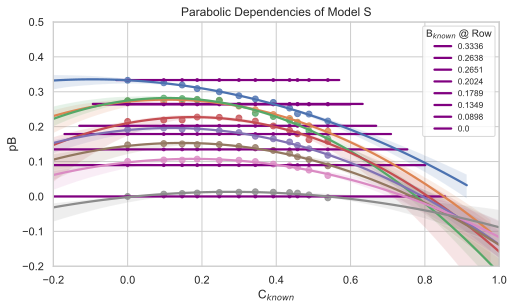

Untruncated Values
Bknown @ Row [0.3336, 0.2638, 0.2651, 0.2024, 0.1789, 0.1349, 0.0898, 0.0]
Bmax @ Row [0.332872, 0.275891, 0.281648, 0.227534, 0.196123, 0.151588, 0.107047, 0.01354]


In [8]:
quick_scrip()

# the fitted curves look parabolic where the vertex position (h, k) i.e. 
# lies at pBmax and a

In [9]:
def quick_scrip():
    
    """Here we're visualizing the predicted values of bacteria (pB) at each well in a row by
    row basis with respect to the known concetration of C. The lines were expected to be 
    flat if the predictions were perfect, but there is a bit of signal addition given by 
    the bacteria. The addition to the signal is dependant on the concentration of B, 
    
    except that we're removing the signal from the 12th column where there is no Chlamy, which
    means the observed signal and its effect is only there because of the prescence of Chlamy;
    this forces all the parabolas to intercept at 0."""    
    fig, ax = plt.subplots(figsize=(8,4.5))
    
    B_max = [] # maximum [pB] conc. at i_th row
    B_at_row = [] # all [B] conc. at i_th row
    for i in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']:
    #for i in ['A', 'B', 'C', 'E', 'F', 'G', 'H']:
    
        
        #append values
        B_at_row.append(B.loc[i][12])
        B_max.append(max(B.loc[i]))

        # create a regression plot for pB v [C] (C known)
        #sns.regplot(y=B.loc[i], x=C.loc['H'], marker='.', color='purple', )
        sns.regplot(y=pB.loc[i]-pB.loc[i][12], x=C.loc['H'], order=2, truncate=False)


    #labels
    ax.set_title('Truncated Model S: Net Effect of Chlamy')
    ax.set_ylabel('Chlamy_Induced_Pred_Error')
    ax.set_xlabel('C$_{known}$')

    #vis settings
    #ax.set_ylim(-0.2, 0.2)
    #ax.set_xlim(-0.4, 1.0)
    ax.legend(B_at_row, title='B$_{known}$ @ Row')
    plt.show()
    
    # [B]known at row, and that Row's B max
    # Bmax may be a stand-in for the peak (H, K)
    print('Truncated Values')
    print('Bknown @ Row', B_at_row)
    print('Bmax @ Row', B_max)


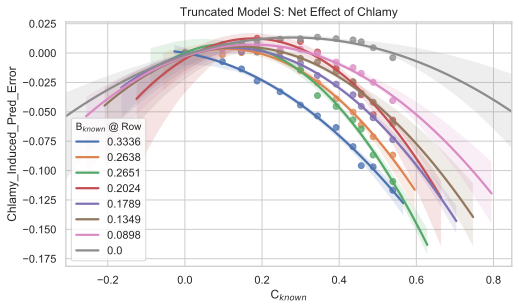

Truncated Values
Bknown @ Row [0.3336, 0.2638, 0.2651, 0.2024, 0.1789, 0.1349, 0.0898, 0.0]
Bmax @ Row [0.3336, 0.2638, 0.2651, 0.2024, 0.1789, 0.1349, 0.0898, 0.0]


In [10]:
quick_scrip()
#plt.legend(size)
# The visualiztion is a Parabola shaped curve f(x) = a(x-h)^2 + k 
#va is negative in these models since the Parabola opens downwards

# When the concentration of bacteria is Zero, the vertex (h, K) of a Parabola is found at the
# the midpoint of the concentration gradient of Chlamy and the maximum predicted concentration
# of the Strains (h=[C]_at_[B]max, k=[B]max). As the concentration of Strain increases 
# (Chlamy remains constant) it shifts the parabola to the left and downwards. Thus f(h) = k*B    
# where H is the estimated value of C at B_max

In [11]:
def h_k(a2a1a0):
    """Analytical calculation of a parabola's vertex....
    In practice here, this calculation does not hold true
    and is therefore obtained numerically. I.e. this 
    function is not used, but is here to test"""
    
    a, b, c = a2a1a0
    
    h = -(b / 2*a)    
    k = a*(h**2) + b*h + c
    
    return h, k

def quick_scrip(pB, C):
    
    """In this function we model the parabolic relationship so that we can
    extract two very important pieces of informaiton from f(x) = -a(x-h)^2 + k :
    'a' and 'h' from each model which will allows us to create a correction factor
    """
    
    # H here is the H'th row not the 'h' of the vertex
    xC = C.loc['H'] # C at 96-well plate row [B]= 0.0
    #y = pB.loc['H'] # [C] of C_only wells

    fig, ax = plt.subplots(figsize=(8,5))
    
    # every plot in the previous visualization has an
    # associated parabolic width: 'a', all are we use
    # this data to obtain an average parabolic width
    a2s = [] # a2*x**2 + a1*x + a0 
    
    # from the predicted fraction data we row's Bmax
    #B_max = []
    
    
    rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    Hs = []   # H must be calculated
    for row in rows:
        
        #B_max.append(max(pB.loc[row]))
        
        
        # we fit know concentration of Chlamy to every row's
        # pB data as the dependant variable
        ypB = pB.loc[row]
        
        # np.polyfit is a quick way to fit a a function to the data, this is
        # then used to extract the a: f(xC) = a*x^2 + b*x + c where [a, b, c]
        # are returned by the polyfit function
        pBfit = np.polyfit(xC, ypB, deg=2)# rcond=None, full=True, w=None, cov=False)
        
       
        # We are interested in getting an average 'a2' (breadth) of the parabolas
        # alternatively we can use the 'a2' of the [B] = 0 parabola or list median
        # thus we append all these values to our list of 'a' values
        a2s.append(pBfit[0])

        # c represents the y-intercept of the fitted parabola, when we truncate his
        # at 0, we essentially bring lower the vertex, and given that the following
        # f(x) = a2*(x-h) + k     where: h= (1/2)*(-b/a2)   and k = f(h) and if (h,k) 
        # represents the vertex, it must be that a0 only increases the vertex's y-position
    
        # k = a*(h)^2 + b*(h) + c
        
        # We store 'c' because we want to subtract it from each individual measurement in the data
        # thus forcing the parabolas all to pass through zero in the graph, we do this because we
        # only want to SEE and Model the effect of the Chlamy on the graph as 'c' is essentially 
        # the only bacteria in the every, we remove it... of course this is a simplification and 
        # the relationship is more involved, but this may be a first approximation and further
        # study into the true relationship might be necessary
        c = pBfit[2]
        
        # Then we replace c in the extracted model from the pBfit because we're only going to fit
        # curve on the effect of Chlamy on each row (EACH ROW HAS A KNOWN AMOUNT OF BACTERIA), if
        # we remove the signal from the bacteria, we're left with the Chlamy's influence
        pBfit[2] = 0 
        
        # Here we create a predictive function from each fitted curve, and..
        pBtor = np.poly1d(pBfit)

        # ...feed it values using linspace to model the curve, the more
        # values we use to create this curve, the better the approximation
        # of  the required h  (h,k)
        xls = np.linspace(-1, 1, 1000000)
        
        # the predictions are stored
        pxls = pBtor(xls)
        plt.plot(xC, ypB-c, '.', xls, pxls)
        
        print(pBtor)
        ############# numerically obtain the location of x-coordinate of the
        ############# vertex as the analytic determinination (h_k) fails 

        # maximum of these predicted 
        # values is k (h, k)
        k=max(pxls)
        
        # the index i.e. the C to which
        # it belongs is h
        h=xls[np.argmax(pxls)]
        #h, k = h_k(pBfit)
        # append this value
        Hs.append(h)
        
        
        ph,pk = h_k(pBfit)
        plt.plot(h,k, 'ro')
        plt.ylim(-0.2, 0.1)
        plt.xlim(-0.5, 1)
        ax.set_xlabel('C')
        ax.set_ylabel('pB')
        #plt.show()
        
    print('a2s',a2s, 'Hs',Hs, sep='\n')
    return a2s, Hs

         2
-0.2992 x - 0.05639 x
         2
-0.5007 x + 0.1066 x
         2
-0.6308 x + 0.1363 x
        2
-0.567 x + 0.199 x
         2
-0.4283 x + 0.1002 x
         2
-0.4003 x + 0.1165 x
         2
-0.3289 x + 0.1147 x
         2
-0.1947 x + 0.1083 x
a2s
[-0.2991569083049154, -0.5007074286173644, -0.6307586331617299, -0.5670477097086982, -0.4283054117272544, -0.4002624589953212, -0.32885834612848996, -0.194667091141451]
Hs
[-0.09424109424109428, 0.10643910643910637, 0.10805110805110796, 0.1755051755051753, 0.11693311693311692, 0.1455071455071455, 0.1744171744171743, 0.278081278081278]


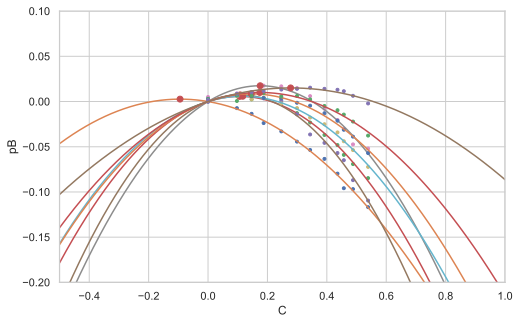

In [12]:
a2s, Hs = quick_scrip(pB, C)

In [13]:
np.mean(a2s)

-0.41872049847315307

In [14]:
def quick_scrip(Hs, pB):
    
    """Given any calibration plate we have empirical values for B and C,
    We know that most of our predictions for B (pB) are not very good so
    here use the known values of B. Model A750 ~ A680 + A540 is the best
    # resulting model, so its the only one where we can use the values
    of pB[12], however, we'll only use"""

    fig, ax = plt.subplots(figsize=(9,5))

    # Modeling the apparent relationship that 'h' in f(h) = a(x - h)**2 + k=0 
    
    # pB[12] # predicted at [C] =0
    # B[12] # empirical at [C] =0
    
    
    Hs = np.array(Hs)

    # emperical measurements at [C]=0
    b_at_C0 = np.array(B[12])
    
    # Create the linear model using the values of empirical 
    #measurementas at column 12, estimated H values
    hfit = np.polyfit(b_at_C0, Hs, deg=1)
    htor = np.poly1d(hfit)
    
    xp = np.linspace(-0.05, .4)
    plt.plot(b_at_C0, Hs, 'ro', xp, htor(xp))
    
    ax.set_xlabel('B')
    ax.set_ylabel('h in (h,k)')
    print(B[12])
    print(Hs)
    print(hfit)
    plt.show()
    return hfit

A    0.3336
B    0.2638
C    0.2651
D    0.2024
E    0.1789
F    0.1349
G    0.0898
H    0.0000
Name: 12, dtype: float64
[-0.09424109  0.10643911  0.10805111  0.17550518  0.11693312  0.14550715
  0.17441717  0.27808128]
[-0.84756841  0.2819184 ]


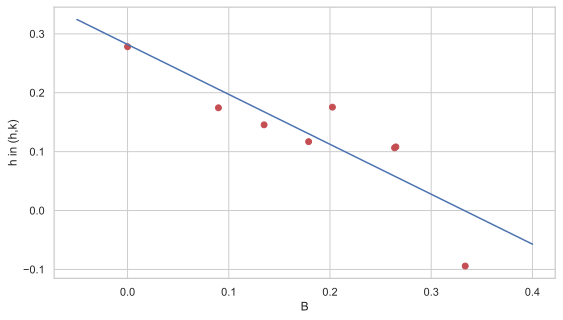

In [15]:
#### IMPORTATNT ####

# As we have noted, the VERTEX's (h, k) 'H' value seems to be a funcion 
# of the predicted  bacterial concentration (pB) thus we can thus use 
# this knowledge to obtain the H the composition of a model from the
# empirical data, this model can then be applied to measurements
# using the same SynCom and measurements

hfit = quick_scrip(Hs, pB)

In [16]:
np.poly1d(hfit)(.4)

-0.057108962105472005

# Save Correcting Paramaters

In [17]:
# create a dataframe that saves the information

# col_labels = ['a1', 'a2', 'a3', 'a4',
#               'a5', 'a6', 'a8', 'a8',
#               'hfit_slope', 'hfit_yint']
# data = a2s[:]
# data.append(hfit[0])
# data.append(hfit[1])
# data = np.array(data).reshape(1,10)

# corval = pd.DataFrame(data=data, columns=col_labels)

In [18]:
#corval.to_csv('corr_model_a680_a540_a750.csv')

# Family of Parabolas

In [19]:
def quick_plot(a2s, hfit):
    a2 = np.mean(a2s)

    fB = np.linspace(0.0,0.6, 10)

    Htor = np.poly1d(hfit, )
    
    
    # A big assumption has to be made which is a good first approximation
    # at refining the predictions of pB... First the assumption has to
    # be made a
    
    # First we note that in the truncated parabolas, the peak (h, k)
    # represented by (pB, C@pBmax) is a function of the actual
    # concentration of B, that is it moves left as the concentration
    # of Bacteria increases. If we create a regression of the,
    # pBmax vs C@pBmax relationship, and then given any prediction pB
    # assume it represents k, we can obtaine 'h'.... given an 'h' we
    # can 
    
    pH = Htor(fB)


    fC = np.linspace(-0.6, 0.6, 100)
    for h in pH:

        b = -2*a2*h
        parabola = [a2, b , 0]
        
        pary = np.poly1d(parabola)

        plt.plot(fC, pary(fC) )
        plt.xlim((-0.1, 0.6))    
        plt.ylim((-0.15, 0.15))

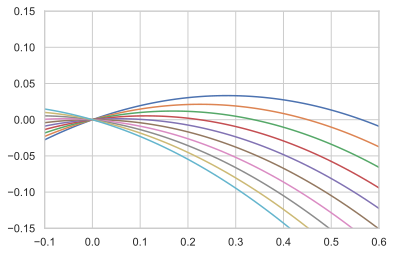

In [20]:
quick_plot(a2s, hfit)

In [21]:
# # There are 3 options about which a2 to use, a2 refers to the breadth of the 
# # correcting parabolas. These are either:
# # the average, the median, or a2 @ [B]=0

# a2_at_b0 =  -0.194667091141451 # this we know has  good fit independant of bacteria
# a2_medn = np.median(a2s) # this should be more robust to outliers
# a2_mean = np.mean(a2s) # this is the median

# p_h = htor(pB)

# #
# b = -2*a2_medn*p_h
# corr_func = np.poly1d(np.array([a2_medn, b, 0 ])) # use this to test things, but this block
# # isn't necessary

In [22]:
def  corr_func_Bsc(pB, pC, a2s, hfit, which_a=None):
    
    # There are 3 options about which a2 to use,
    # a2 refers to the breadth of the correcting
    # parabola. These are either the:
        # mean
        # median
        # a2 @ [B]= 0 (Row12)
    
    # WHICH Parabolic BREADTH to use for correction
    if which_a =='mean':
        a2 = np.mean(a2s) # this is the mean
        
    elif which_a =='median':
        a2 = np.median(a2s) # this should be more robust to outliers
    
    # set as default
    else:
        a2 = -0.499525586 #global over 3 models... also this has the effect
        # of 'canceling out' the need for 'b' as 

    # given the fitted line avove, use poly1d to create a 
    # prediction function
    htor = np.poly1d(hfit)
    
    # takes in the predicted pB and spits out a likely H
    lH = htor(pB)
    
    
    # IMPORTANT #
    # this is from an algebraic manipulation of the parabolic function
    # in polynomial and parabolic form where h = -b/2*a2 --- since we
    # "know: a2 and p_h is dependant on the concetration of B we 
    # estimate the likely value of b in f(x) = a2*x^2 + b*x + c
    b = np.multiply(-2*a2,lH)    
    cv_tor = np.poly1d([a2, b, 0])
    
    return cv_tor(pC)

# Apply Correcting Functions
    
    The reason why I think this method works, is because the Bae Beer-Lambert
    models can predict the values of Chlamy fairly accurately, therefore we
    can piggy back off these values and correct the values of  Bacteria by 
    'adding' back that Chlamy steals 

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,700,710,720,730,740,750,B_p750,C_p750,B,C
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.4,0.50,1.0938,0.0618,1.4928,0.0686,0.8732,0.0660,...,0.9723,0.8896,0.8541,0.8298,0.8166,0.8032,0.216128,0.569061,0.3336,0.5389
A2,A,2,0.4,0.46,1.0292,0.0746,1.3929,0.0742,0.8300,0.0714,...,0.9243,0.8486,0.8149,0.7924,0.7793,0.7660,0.236106,0.512043,0.3336,0.4881
A3,A,3,0.4,0.42,0.9685,0.0768,1.2995,0.0818,0.7890,0.0758,...,0.8680,0.7985,0.7672,0.7458,0.7334,0.7209,0.237067,0.468401,0.3336,0.4572
A4,A,4,0.4,0.38,0.9106,0.0732,1.2021,0.0791,0.7450,0.0742,...,0.8222,0.7584,0.7300,0.7094,0.6977,0.6858,0.253240,0.417700,0.3336,0.4359
A5,A,5,0.4,0.34,0.8852,0.0785,1.1458,0.0879,0.7252,0.0804,...,0.7939,0.7354,0.7079,0.6883,0.6763,0.6646,0.269521,0.380806,0.3336,0.3920


,cv,B_og750,B,B_p750,C,C_p750
well,,,,,,
A6,-0.041313,0.279407,0.3336,0.320720,0.3437,0.336201
A7,-0.030570,0.288620,0.3336,0.319191,0.2995,0.287472
B10,-0.002894,0.274094,0.2638,0.276988,0.1467,0.140453
D9,-0.000408,0.227534,0.2024,0.227942,0.1872,0.182612
E12,-0.000634,0.191655,0.1789,0.192289,0.0000,-0.005198
F2,-0.028558,0.106013,0.1349,0.134572,0.4881,0.498756
G8,0.017909,0.103585,0.0898,0.085675,0.2467,0.236918
H12,0.000000,-0.000000,0.0000,-0.000000,0.0000,0.000000
H6,0.034536,0.013540,0.0000,-0.020996,0.3437,0.333699


'known v corrected B'

array([[1.        , 0.99121422],
       [0.99121422, 1.        ]])

'known v predicted B'

array([[1.        , 0.94919095],
       [0.94919095, 1.        ]])

'known v predicted C'

array([[1.        , 0.99768383],
       [0.99768383, 1.        ]])

'original'

B_p750


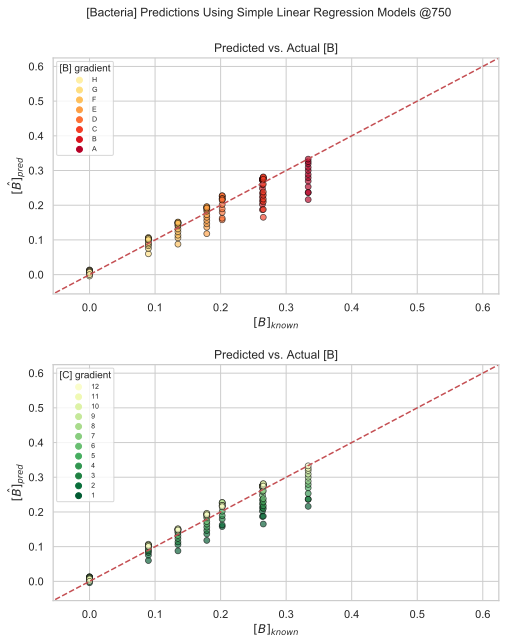

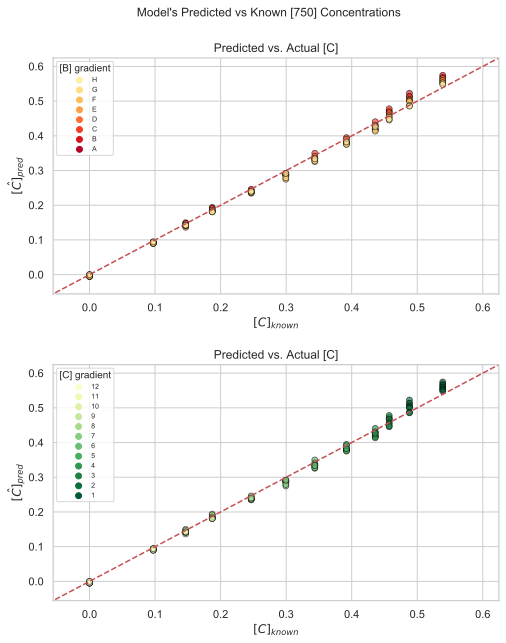

'corrected'

B_p750


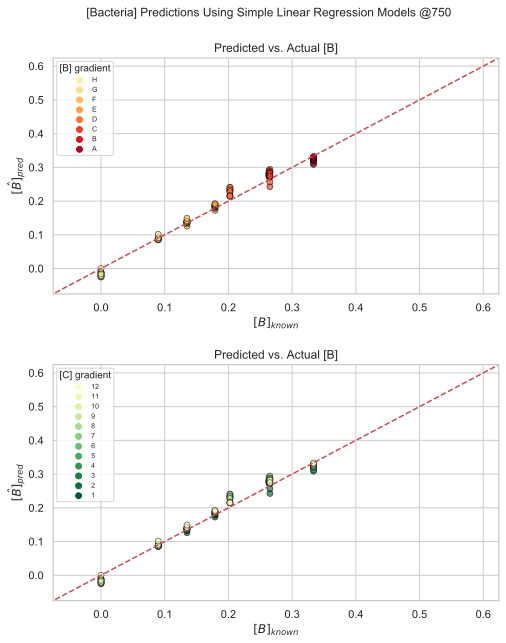

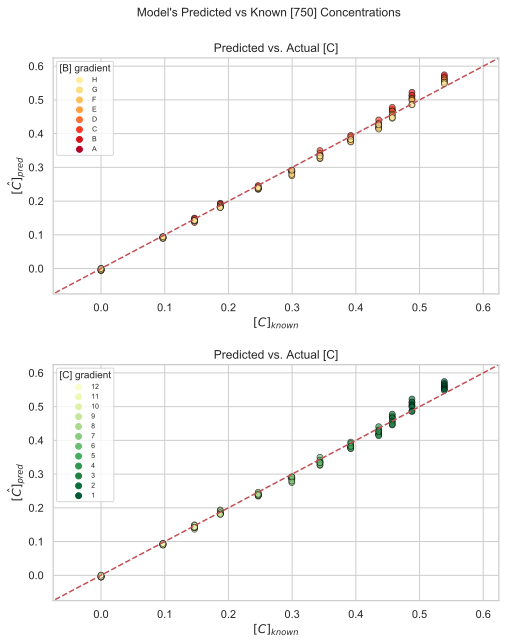

In [23]:
tcdf = df.copy()

tcdf.head()

tcdf['B_og'+WC] = tcdf['B_p'+WC].copy()
#tcdf['Ctmp_'+WC] = tcdf['C_p'+WC].copy()


# CORRECT pB
# use the uncorrected values to correct these 
tcdf['cv'] =  tcdf.apply(lambda x: corr_func_Bsc(x['B_p'+WC], x['C_p'+WC], a2s, hfit,
                         which_a=None), axis=1)

tcdf['B_p'+WC] = tcdf['B_og'+WC] - tcdf['cv']


# sample of corrections made
tcdf[[ 'cv', 'B_og'+WC,'B', 'B_p'+WC, 'C', 'C_p'+WC]].sample(n=10).sort_values(by='well')


# B_known vs B_corrected 
'known v corrected B'
np.corrcoef(x=tcdf['B'], y=tcdf['B_p'+WC])

# B_known vs B_original_predictions
'known v predicted B'
np.corrcoef(x=tcdf['B'], y=tcdf['B_og'+WC])

# C_known vs C_predicted
'known v predicted C'
np.corrcoef(x=tcdf['C'], y=tcdf['C_p'+WC])

'original'
plot_pred_vs_known(df, column=WC, ml_model=False)


'corrected'
plot_pred_vs_known(tcdf, column=WC, ml_model=False)

In [24]:
np.poly1d(hfit)(.05)

0.23953998253089825

In [25]:
2*(.2394766)*.4995

0.2392371234

In [26]:
tcdf[tcdf['B']==0]

,row,col,B_lbl,C_lbl,A600,A600_sdv,A680,A680_sdv,A720,A720_sdv,...,720,730,740,750,B_p750,C_p750,B,C,B_og750,cv
well,,,,,,,,,,,,,,,,,,,,,
H1,H,1,0.0,0.50,0.7167,0.0805,1.1581,0.0779,0.5859,0.0711,...,0.5846,0.5621,0.5498,0.5389,-0.010160,0.547872,0.0,0.5389,-0.003956,0.006204
H2,H,2,0.0,0.46,0.6463,0.0880,1.0471,0.0985,0.5432,0.0889,...,0.5296,0.5092,0.4981,0.4881,-0.012586,0.485571,0.0,0.4881,0.004534,0.017120
H3,H,3,0.0,0.42,0.6162,0.0927,0.9830,0.0912,0.5140,0.0813,...,0.4962,0.4770,0.4666,0.4572,-0.012675,0.447857,0.0,0.4572,0.009622,0.022297
H4,H,4,0.0,0.38,0.5726,0.0903,0.9208,0.0995,0.4819,0.0884,...,0.4743,0.4555,0.4454,0.4359,-0.014059,0.426149,0.0,0.4359,0.011207,0.025266
H5,H,5,0.0,0.34,0.5283,0.0923,0.8430,0.0995,0.4451,0.0902,...,0.4273,0.4100,0.4003,0.3920,-0.018438,0.382417,0.0,0.3920,0.012251,0.030689
H6,H,6,0.0,0.30,0.4717,0.0964,0.7464,0.0976,0.4016,0.0935,...,0.3761,0.3602,0.3514,0.3437,-0.020996,0.333699,0.0,0.3437,0.013540,0.034536
H7,H,7,0.0,0.25,0.4162,0.1038,0.6519,0.1021,0.3603,0.1011,...,0.3280,0.3140,0.3065,0.2995,-0.024379,0.291721,0.0,0.2995,0.012249,0.036628
H8,H,8,0.0,0.21,0.3344,0.0945,0.5329,0.0950,0.2918,0.0934,...,0.2704,0.2588,0.2524,0.2467,-0.025109,0.240262,0.0,0.2467,0.011405,0.036514
H9,H,9,0.0,0.17,0.2760,0.1070,0.4347,0.1105,0.2462,0.1058,...,0.2056,0.1967,0.1917,0.1872,-0.023207,0.180723,0.0,0.1872,0.009869,0.033076
